In [1]:
from swemnics.problems import TidalProblem
from swemnics import solvers as Solvers
from mpi4py import MPI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dolfinx import fem as fe
from tqdm import tqdm

import pandas as pd
from scipy.optimize import minimize
import seaborn as sns 
from typing import Callable, Dict, List, Tuple, Any, Union

from plotting import plot_simulation_results, create_comparison_figure
from fourd_var import*
from dca_utils import*

sns.set_palette("bright")
plt.style.use("mystyle1.mplstyle")

In [2]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

problem_params = {
    'nx': 20,
    'ny': 5,
    'dt': 3600,
    't': 0,
    't_final': 7*24*60*60, # 7 days 
    'num_steps': int(np.ceil((7*24*60*60)/3600)),
    'num_windows': 4,
    'fric_law': 'mannings',    #friction law either quadratic or linear
    'sol_var': 'h'             #solution variable either h or hu
}

solver_params = {"rtol": 1e-5,
          "atol": 1e-6,
          "max_it":10,
          "relaxation_parameter":1.0,
          "ksp_type": "gmres",
          "pc_type": "ilu",
          "ksp_ErrorIfNotConverged": False,
          }#,"pc_factor_mat_solver_type":"mumps"}


In [3]:
assert problem_params['num_steps'] == int(np.ceil(problem_params['t_final']/problem_params['dt']))
obs_frequency = 2  # observe system every 4th time step
true_signal, prob, stations, state_coords = get_true_signal(problem_params,
                                                            'tidal',
                                                            solver_params, 
                                                            create_problem_solver,
                                                            obs_frequency)

V scalar FunctionSpace(<Mesh #0>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))
V_coords shape: (126, 3)


In [4]:
print(f"Total Dof =  H_dof x u_dof x v_dof: {true_signal.u.x.array.shape}")
print(f"Observation Frequency: {obs_frequency}")
print(f"Number of Stations x (H,u,v): {stations.shape}")
print(f"N Time Steps, N Stations, N Variables: {true_signal.vals.shape}")
print(f"Number of Adjoints Saved: {len(true_signal.saved_adjoints)}")
print(f"Adjoint Size: {true_signal.saved_adjoints[0].shape}")
print(f"Number of states Saved: {len(true_signal.saved_states)}")
print(f"State Size: {true_signal.saved_states[0].shape}")

Total Dof =  H_dof x u_dof x v_dof: (378,)
Observation Frequency: 2
Number of Stations x (H,u,v): (63, 3)
N Time Steps, N Stations, N Variables: (169, 63, 3)
Number of Adjoints Saved: 168
Adjoint Size: (126, 126)
Number of states Saved: 168
State Size: (126,)


In [5]:
obs_std=0.8
obs_time_freq = 4
total_steps = int((problem_params['t_final']/problem_params['dt']) + 1)
problem_params['num_steps'] = int(np.ceil((7*24*60*60)/3600)/problem_params['num_windows']) # Size of each assimilation window
obs_per_window = problem_params['num_steps'] // obs_time_freq 

print(f"Total Steps: {total_steps}\n"
      f"Total Assimilation Windows: {problem_params['num_windows']}\n"
      f"Steps per Window: {problem_params['num_steps']}\n"
      f"Obs Frequency: {obs_time_freq}\n"
      f"Total Obs: {obs_per_window * problem_params['num_windows']}\n"
      f"Number Stations: {stations.shape[0]}\n"
      f"Obs per Window: {obs_per_window}\n")


# Create synthetic observations
obs_spatial_indices = find_obs_indices(stations, state_coords)
obs_indices_per_window, obs_time_indices = setup_observation_indices(problem_params['num_steps'], obs_time_freq, total_steps)

print(f"Observation Spatial Indices: {obs_spatial_indices}\n\n"
      f"Observation Time Indices: {obs_time_indices}\n\n"
      f"Observation Time Indices per Window: {obs_indices_per_window}\n\n"
      )

hb = 10 + (stations[:, 0]*0)
y_obs = generate_observations(true_signal, hb, obs_time_indices, obs_std)


# Generate Background,Observation, and Predicted Error Covariance Matrices
state_dim = true_signal.problem.h_b.x.array.shape[0]
obs_dim = stations.shape[0]

# Observation Matrix
H = np.zeros((obs_dim, state_dim))
H[np.arange(obs_dim), obs_spatial_indices] = 1.0

# Observation Covariance 
R = np.eye(obs_dim) * (obs_std**2)

# Background Covariance 
inflation_factor=3.5
B = inflation_factor*np.eye(state_dim) 

# Predicted Covariance
P = H @ B @ H.T 

# Get Inverse Covariance matrices
R_inv = np.linalg.inv(R)
B_inv = np.linalg.inv(B) 
P_inv = np.linalg.inv(P)

print(f"State Dimension: {state_dim}\n"
      f"Observation Dimension: {obs_dim}\n"
      f"Background Covariance Matrix Shape B: {B.shape}\n"
      f"Observation Covariance Matrix Shape R: {R.shape}\n"
      f"Predicted Error Covariance Matrix shape P: {P.shape}\n"
      f"Observation Matrix Shape H: {H.shape}\n")


Total Steps: 169
Total Assimilation Windows: 4
Steps per Window: 42
Obs Frequency: 4
Total Obs: 40
Number Stations: 63
Obs per Window: 10

Observation Spatial Indices: [  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124]

Observation Time Indices: [  0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68
  72  76  80  84  88  92  96 100 104 108 112 116 120 124 128 132 136 140
 144 148 152 156 160 164 168]

Observation Time Indices per Window: [ 0  4  8 12 16 20 24 28 32 36 40]


State Dimension: 126
Observation Dimension: 63
Background Covariance Matrix Shape B: (126, 126)
Observation Covariance Matrix Shape R: (63, 63)
Predicted Error Covariance Matrix shape P: (63, 63)
Observation Matrix Shape H: (63, 126)



In [6]:
bayes_analysis = run_assimilation(
                                  problem_params,
                                  solver_params,
                                  stations,
                                  y_obs,
                                  obs_per_window,
                                  obs_spatial_indices,
                                  obs_time_indices,
                                  H, B_inv, R_inv, P_inv, hb,
                                'tidal',
                                create_problem_solver,
                                bayes_cost_function,
                                grad_bayes_cost_function
                             )

Processing windows:   0%|          | 0/4 [00:00<?, ?window/s]

obs times:[ 0  4  8 12 16 20 24 28 32 36]

V scalar FunctionSpace(<Mesh #1>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))
Solver Time 1: 0

 Optimization completed:
  Success: False
  Status: 2
  Message: ABNORMAL: 
  Final cost: 355.0094626248032
  Iterations: 0
  Function evaluations: 21
Gradient at solution: [ 1.06672303e-02 -3.11408432e-02  5.14607389e-02 -2.65330392e-04
  4.69273106e-03  5.16859667e-02  5.72422541e-02  5.82951707e-02
  1.14006366e-01  9.61564593e-02  1.22168090e-01  9.01538838e-02
  1.02485501e-01  1.55314254e-01  1.35110898e-01  1.59067946e-01
  1.35837718e-01  1.16946596e-01  1.29829400e-01  1.91670090e-01
  1.53033983e-01  1.92550127e-01  1.69634486e-01  1.44909281e-01
  1.38553076e-01  1.35215956e-01  2.33719118e-01  2.24917013e-01
  1.99762381e-01  1.72621067e-01  1.58365223e-01  1.40339103e-01
  2.60362555e-01  2.50069173e-01  2.27252896e-01  1.98686217e-01
  1.81673434e-01  1.57492890e-01  2.80903385e-01  2.70099222e-01
  2.5028680

Processing windows:  25%|██▌       | 1/4 [00:19<00:57, 19.14s/window]

/////////////////////////////////////// Window 1 Completed ////////////////////////////////////////////////// 


V scalar FunctionSpace(<Mesh #2>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))
Solver Time 1: 151200

 Optimization completed:
  Success: False
  Status: 2
  Message: ABNORMAL: 
  Final cost: 341.12135518001855
  Iterations: 0
  Function evaluations: 21
Gradient at solution: [ 0.01011533 -0.03177843  0.05470438 -0.00076742  0.00278756  0.05063823
  0.05550995  0.05696057  0.11247786  0.09439281  0.12026866  0.08811531
  0.10052218  0.15301743  0.13282293  0.15658252  0.13344654  0.11426768
  0.12670074  0.18895572  0.15028934  0.1897216   0.16664545  0.14188814
  0.13487698  0.13211888  0.23065094  0.22201567  0.19645771  0.16935554
  0.15450327  0.1368107   0.25795751  0.24748581  0.22407405  0.19570055
  0.17762559  0.15377695  0.27777203  0.26752771  0.24753416  0.22014141
  0.20174684  0.17549062  0.29475867  0.2840858   0.26713331  0.24159336
 

Processing windows:  50%|█████     | 2/4 [00:37<00:37, 18.97s/window]

/////////////////////////////////////// Window 2 Completed ////////////////////////////////////////////////// 


V scalar FunctionSpace(<Mesh #3>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))
Solver Time 1: 302400
Iteration 1: Cost = 308.063130

 Optimization completed:
  Success: False
  Status: 2
  Message: ABNORMAL: 
  Final cost: 308.06312987075574
  Iterations: 1
  Function evaluations: 44
Gradient at solution: [ 0.00849129 -0.02786564  0.04762529 -0.0009875   0.00305435  0.04557324
  0.04986629  0.05122654  0.101562    0.08500394  0.10853752  0.0793298
  0.0906424   0.13768467  0.1195024   0.14101724  0.12025278  0.10298426
  0.11443232  0.16937385  0.13504567  0.170278    0.15049075  0.1278447
  0.1216662   0.11914682  0.2056645   0.19840121  0.17685533  0.15267146
  0.1391759   0.12336257  0.22899897  0.22020278  0.20091453  0.17585414
  0.1603226   0.1385452   0.24709027  0.23750776  0.22063586  0.1970667
  0.18119647  0.15814771  0.2608117   0.251416

Processing windows:  75%|███████▌  | 3/4 [01:18<00:28, 28.76s/window]

/////////////////////////////////////// Window 3 Completed ////////////////////////////////////////////////// 


V scalar FunctionSpace(<Mesh #4>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))
Solver Time 1: 453600
Iteration 1: Cost = 309.725343

 Optimization completed:
  Success: False
  Status: 2
  Message: ABNORMAL: 
  Final cost: 309.7253432591655
  Iterations: 1
  Function evaluations: 46
Gradient at solution: [ 9.80376768e-03 -2.86920456e-02  4.77897572e-02 -5.96474531e-05
  3.82436866e-03  4.79173788e-02  5.24127415e-02  5.40277675e-02
  1.06027222e-01  8.91725585e-02  1.12889735e-01  8.30452485e-02
  9.51045309e-02  1.42779360e-01  1.25242213e-01  1.46246823e-01
  1.25283099e-01  1.07703866e-01  1.19667824e-01  1.74846133e-01
  1.41628665e-01  1.75899867e-01  1.56284307e-01  1.33324745e-01
  1.27201482e-01  1.24661090e-01  2.11225443e-01  2.04172338e-01
  1.82906722e-01  1.58604523e-01  1.45446804e-01  1.28950131e-01
  2.35663847e-01  2.26601838e-01  2

Processing windows: 100%|██████████| 4/4 [02:02<00:00, 30.71s/window]

/////////////////////////////////////// Window 4 Completed ////////////////////////////////////////////////// 




In [7]:
# bayes_analysis = run_assimilation(problem_params, solver_params, stations, y_obs, obs_per_window,
#                              obs_indices_per_window,
#                              H, B_inv, R_inv, P_inv, hb,
#                              'tidal',
#                              create_problem_solver,
#                              bayes_cost_function,
#                              grad_bayes_cost_function
#                              )

In [8]:
# dci_analysis = run_assimilation(problem_params, solver_params, stations, y_obs, obs_per_window,
#                              obs_indices_per_window,
#                              H, B_inv, R_inv, P_inv, hb,
#                              'tidal',
#                              create_problem_solver,
#                              dci_cost_function, 
#                             grad_dci_cost_function
#                              )

In [9]:
# dci_wme_analysis = run_assimilation(problem_params, solver_params, stations, y_obs, obs_per_window,
#                              obs_indices_per_window,
#                              H, B_inv, R_inv, P_inv, hb,
#                              'tidal',
#                              create_problem_solver,
#                              dci_wme_cost_function,
#                              grad_dci_wme_cost_function
#                              )

In [ ]:
print(true_signal.vals.shape, bayes_analysis.shape, y_obs.shape)
print(true_signal.vals[obs_indices].shape, bayes_analysis[obs_indices].shape)

(169, 32, 3) (169, 32, 3) (43, 32)
(43, 32, 3) (43, 32, 3)


In [ ]:
# bayes_analysis
# dci_analysis

In [10]:
bayes_rmse = np.sqrt(np.mean((true_signal.vals[:,:,0] - bayes_analysis[:,:,0]) ** 2))
bayes_rmse

np.float64(0.019125583453501564)

In [ ]:
dci_rmse = np.sqrt(np.mean((true_signal.vals[:,:,0] - dci_analysis[:,:,0]) ** 2))
dci_rmse

np.float64(0.0001684577440841142)

In [ ]:
dci_wme_rmse = np.sqrt(np.mean((true_signal.vals[:,:,0] - dci_wme_analysis[:,:,0]) ** 2))
dci_wme_rmse

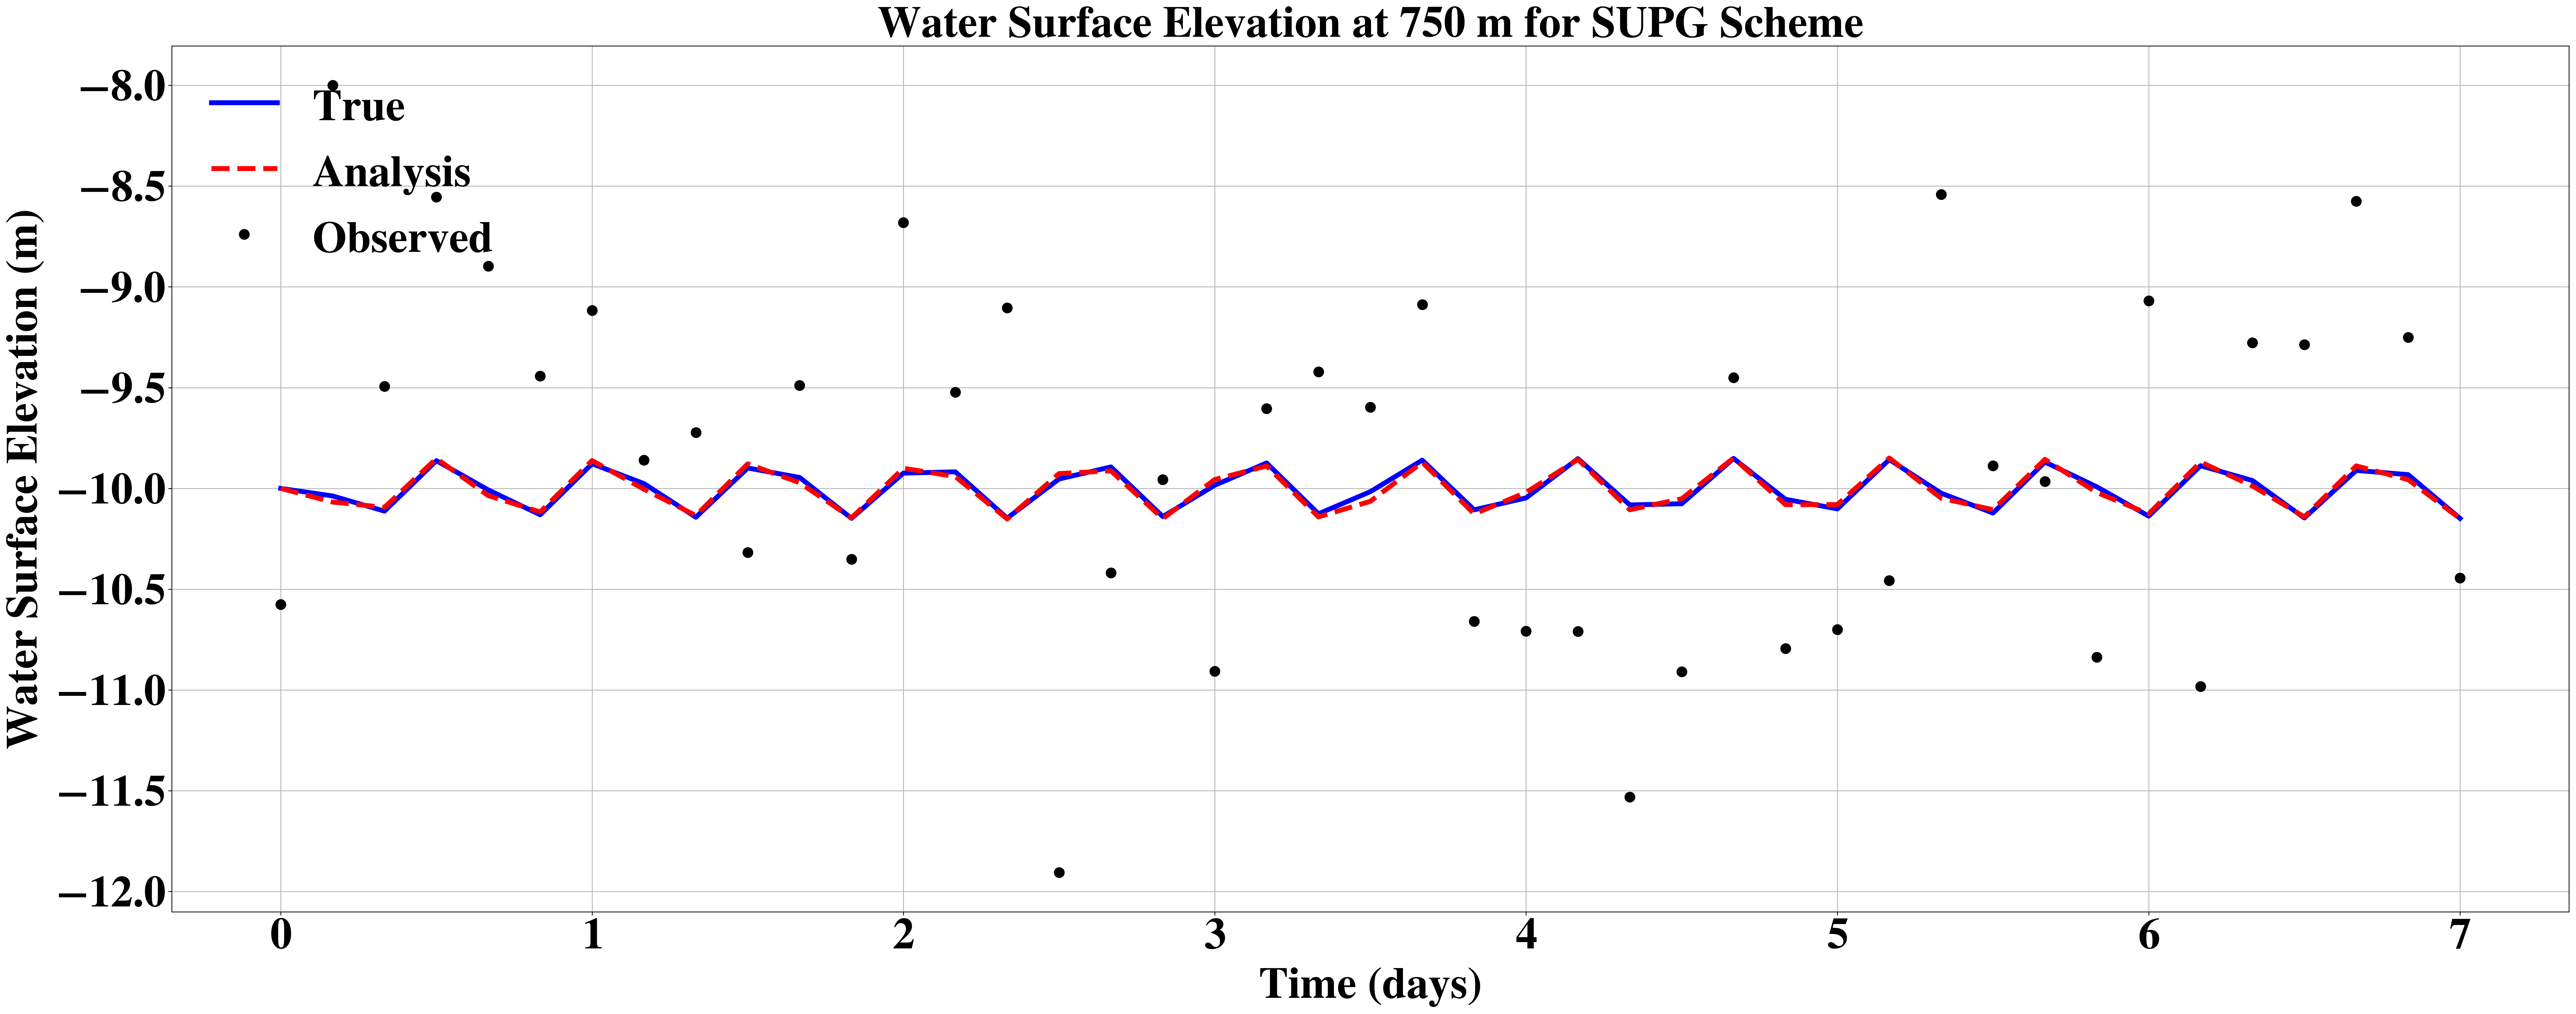

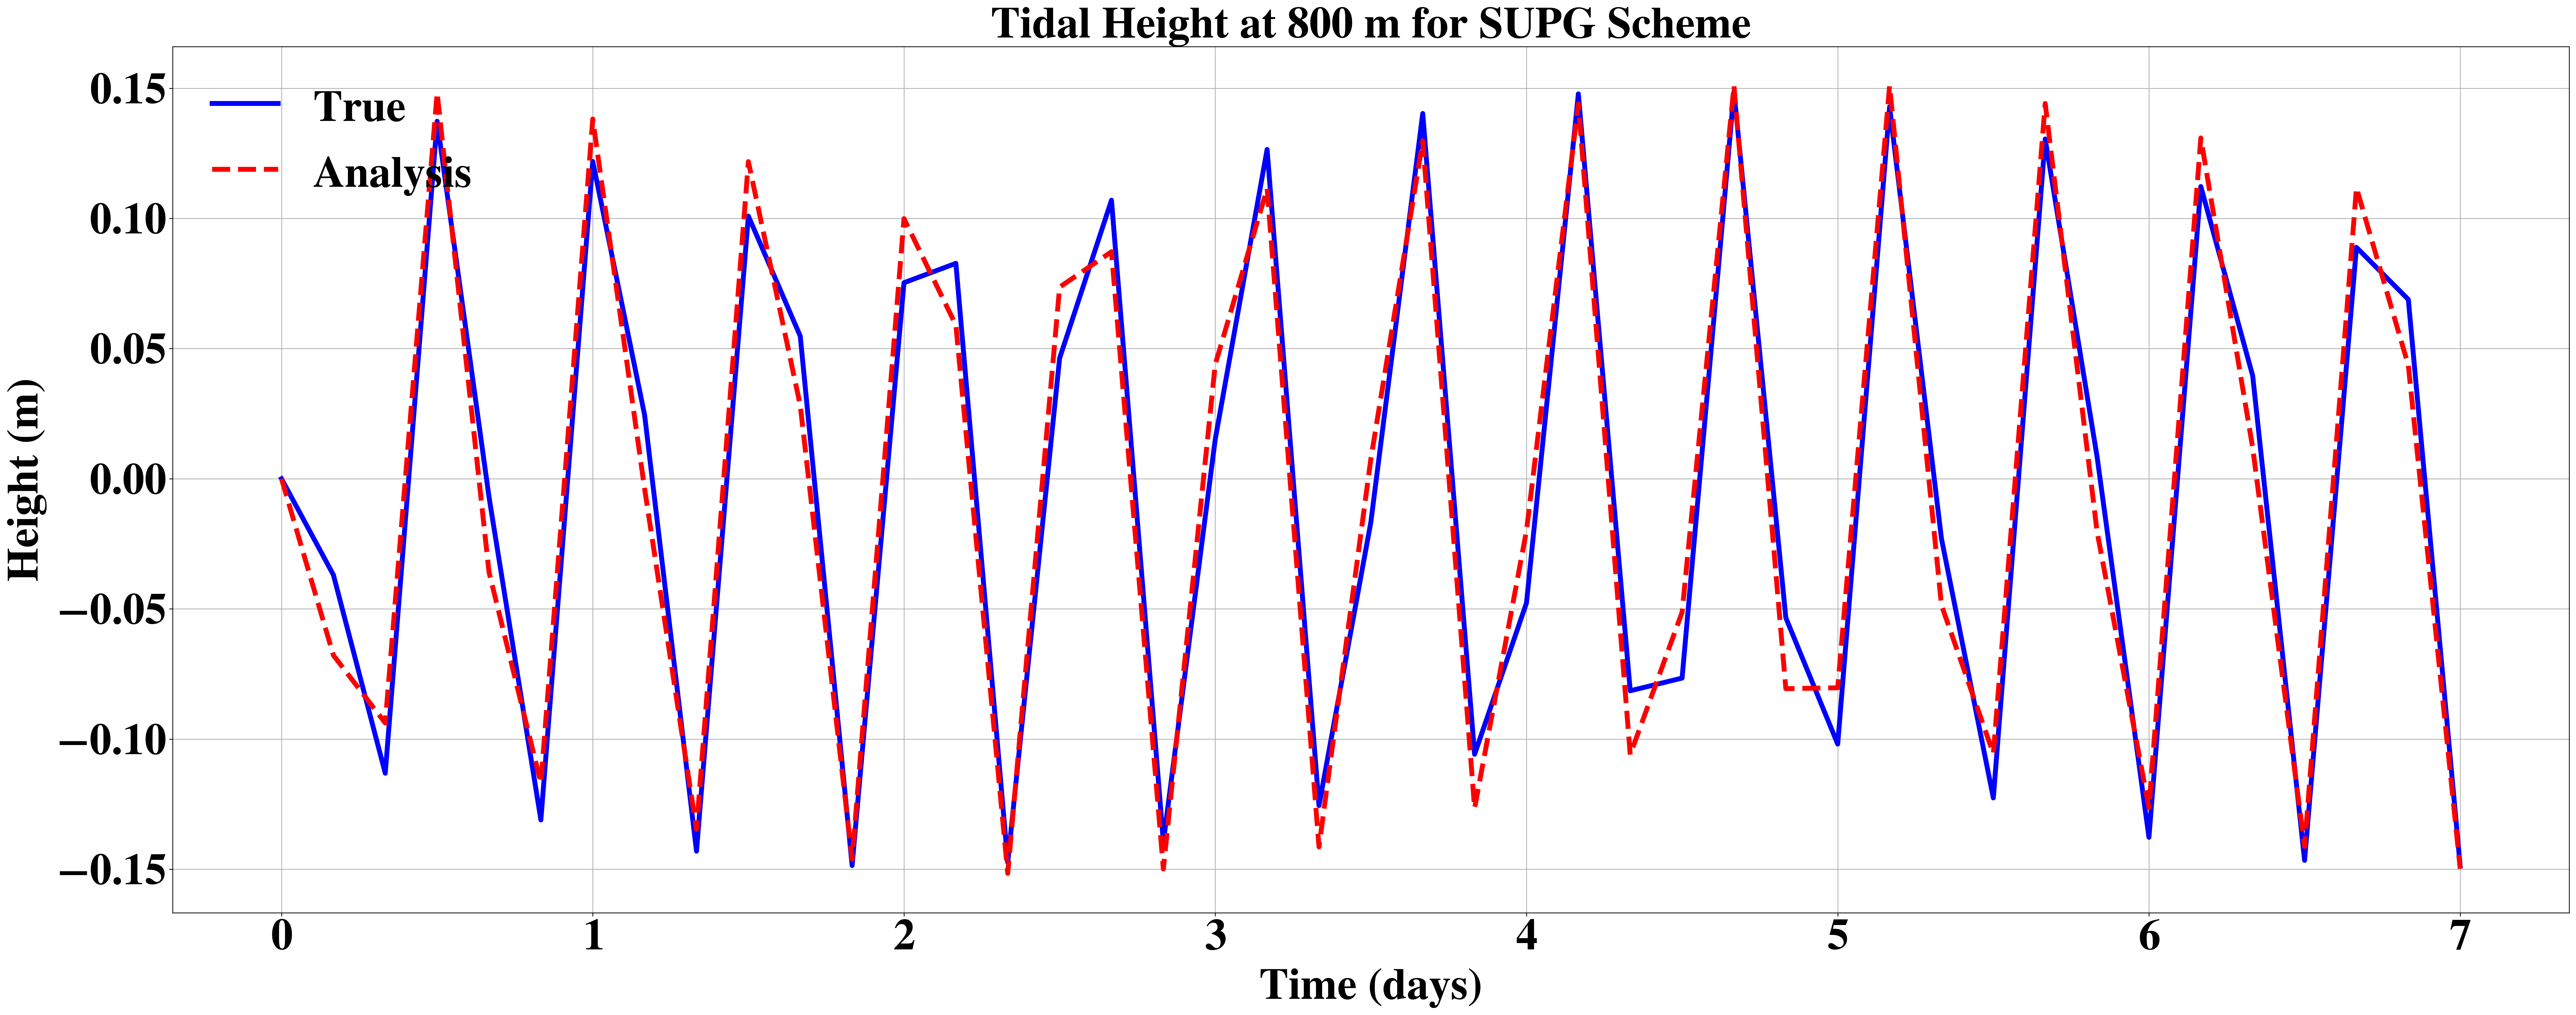

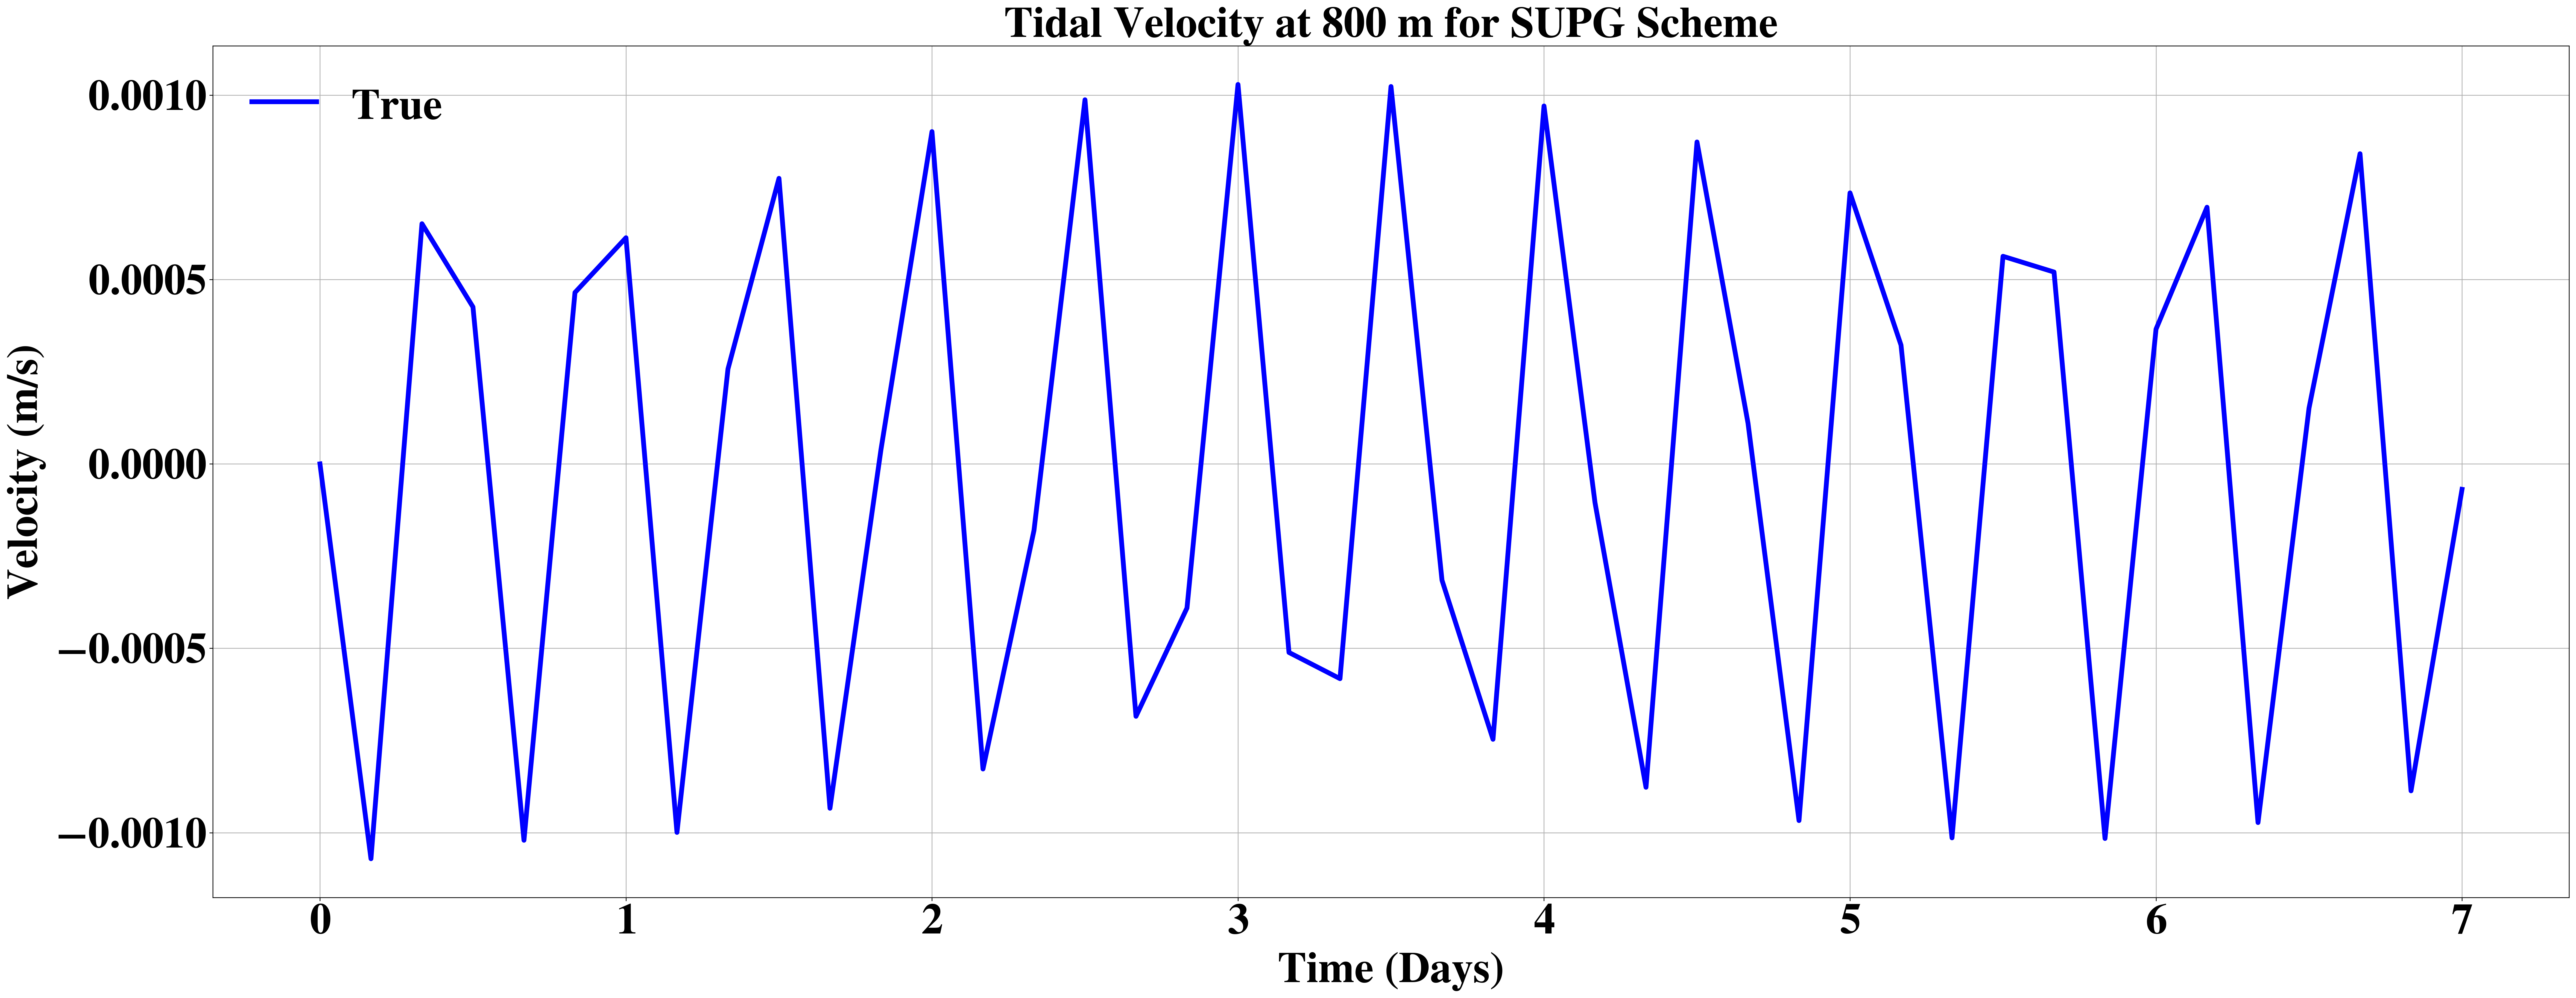

In [11]:
plot_params = {
    "lines.linewidth": 5,
    "lines.markersize": 10,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 45,
    "legend.frameon": False,
    "xtick.labelsize": 45,
    "ytick.labelsize": 45,
    "axes.labelsize": 45,
    "axes.labelpad": 10,
    "axes.titlesize": 45,
    "figure.figsize": (44, 16),
}


plot_simulation_results(true_signal, bayes_analysis, y_obs, hb, problem_params,
                       obs_time_indices, plot_params, save=False, save_prefix="bayes_")

In [ ]:
plot_params = {
    "lines.linewidth": 5,
    "lines.markersize": 10,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 45,
    "legend.frameon": False,
    "xtick.labelsize": 45,
    "ytick.labelsize": 45,
    "axes.labelsize": 45,
    "axes.labelpad": 10,
    "axes.titlesize": 45,
    "figure.figsize": (44, 16),
}


plot_simulation_results(true_signal, bayes_analysis, y_obs, hb, problem_params,
                       obs_indices, plot_params, save=False, save_prefix="bayes_")

In [ ]:
filenames = ["wse", "xvel", "yvel"]

for i, filename in enumerate(filenames):
	with open(f"{name}_p1_{filename}.pkl", 'wb') as f:
		pickle.dump(solver.vals[:,:,i], f)

# np.savetxt(f"{name}_p1_wse.csv", solver.vals[:,:,0], delimiter=",")
# np.savetxt(f"{name}_p1_xvel.csv", solver.vals[:,:,1], delimiter=",")
# np.savetxt(f"{name}_p1_yvel.csv", solver.vals[:,:,2], delimiter=",")

----
# Expiremental

In [ ]:
from scipy.optimize import approx_fprime
import numpy as np


In [ ]:
# bayes_analysis = run_assimilation(problem_params, solver_params, stations, y_obs, obs_per_window,
#                              obs_indices_per_window,
#                              H, B_inv, R_inv, P_inv, hb,
#                              'tidal',
#                              create_problem_solver,
#                              bayes_cost_function,
#                              grad_bayes_cost_function
#                              )

In [ ]:
# load initial state .npy file 
z0 = np.load("initial_state.npy")
zb = np.load("initial_state.npy") 
Qzb = np.load("backgroundQzb.npy")

idx= 0
initial_time = int(idx * problem_params["num_steps"] * problem_params["dt"])
problem_params.update({"t": initial_time})

# Create problem and solver
_, solver = create_problem_solver(
    problem_params, 'tidal', true_signal=False
)
solver.problem.t = initial_time
indices = np.arange(obs_per_window) + (idx * obs_per_window)
yobs_current_window = y_obs[indices]


V scalar FunctionSpace(<Mesh #1>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, []))
USING NONSPHERICAL WELLBALANCED


In [ ]:
def cost_fn(z0):
    total_cost = bayes_cost_function(
        z0,
        zb,
        yobs_current_window,
        obs_indices_per_window[:-1],
        H,
        B_inv,
        R_inv,
        P_inv,
        Qzb,
        solver_params,
        stations,
        hb,
        solver,
        initial_time,
    )
    # print(f"Cost function value: {total_cost}")
    return total_cost

#get gradient for cost function 
def grad_fn(z0):
    grad = grad_bayes_cost_function(
        z0,
        zb,
        yobs_current_window,
        obs_indices_per_window[:-1],
        H,
        B_inv,
        R_inv,
        P_inv,
        Qzb,
        solver_params,
        stations,
        hb,
        solver,
        initial_time,
    )
    return grad 



def cost_function_gradient1(x0, epsilon=1e-6):
    """
    Compute the gradient of the cost function using finite differences.
    """
    # Using central finite differences
    grad = np.zeros_like(x0)
    
    for i in range(len(x0)):
        x_plus = x0.copy()
        x_minus = x0.copy()
        
        x_plus[i] += epsilon
        x_minus[i] -= epsilon
        
        J_plus = cost_fn(x_plus)
        J_minus = cost_fn(x_minus)
        
        grad[i] = (J_plus - J_minus) / (2 * epsilon)
        
    return grad

In [ ]:
# grad_at_init = grad_fn(z0)
# print(f"Gradient at initial state: {grad_at_init}")

In [ ]:
grad_at_init.shape

(126,)

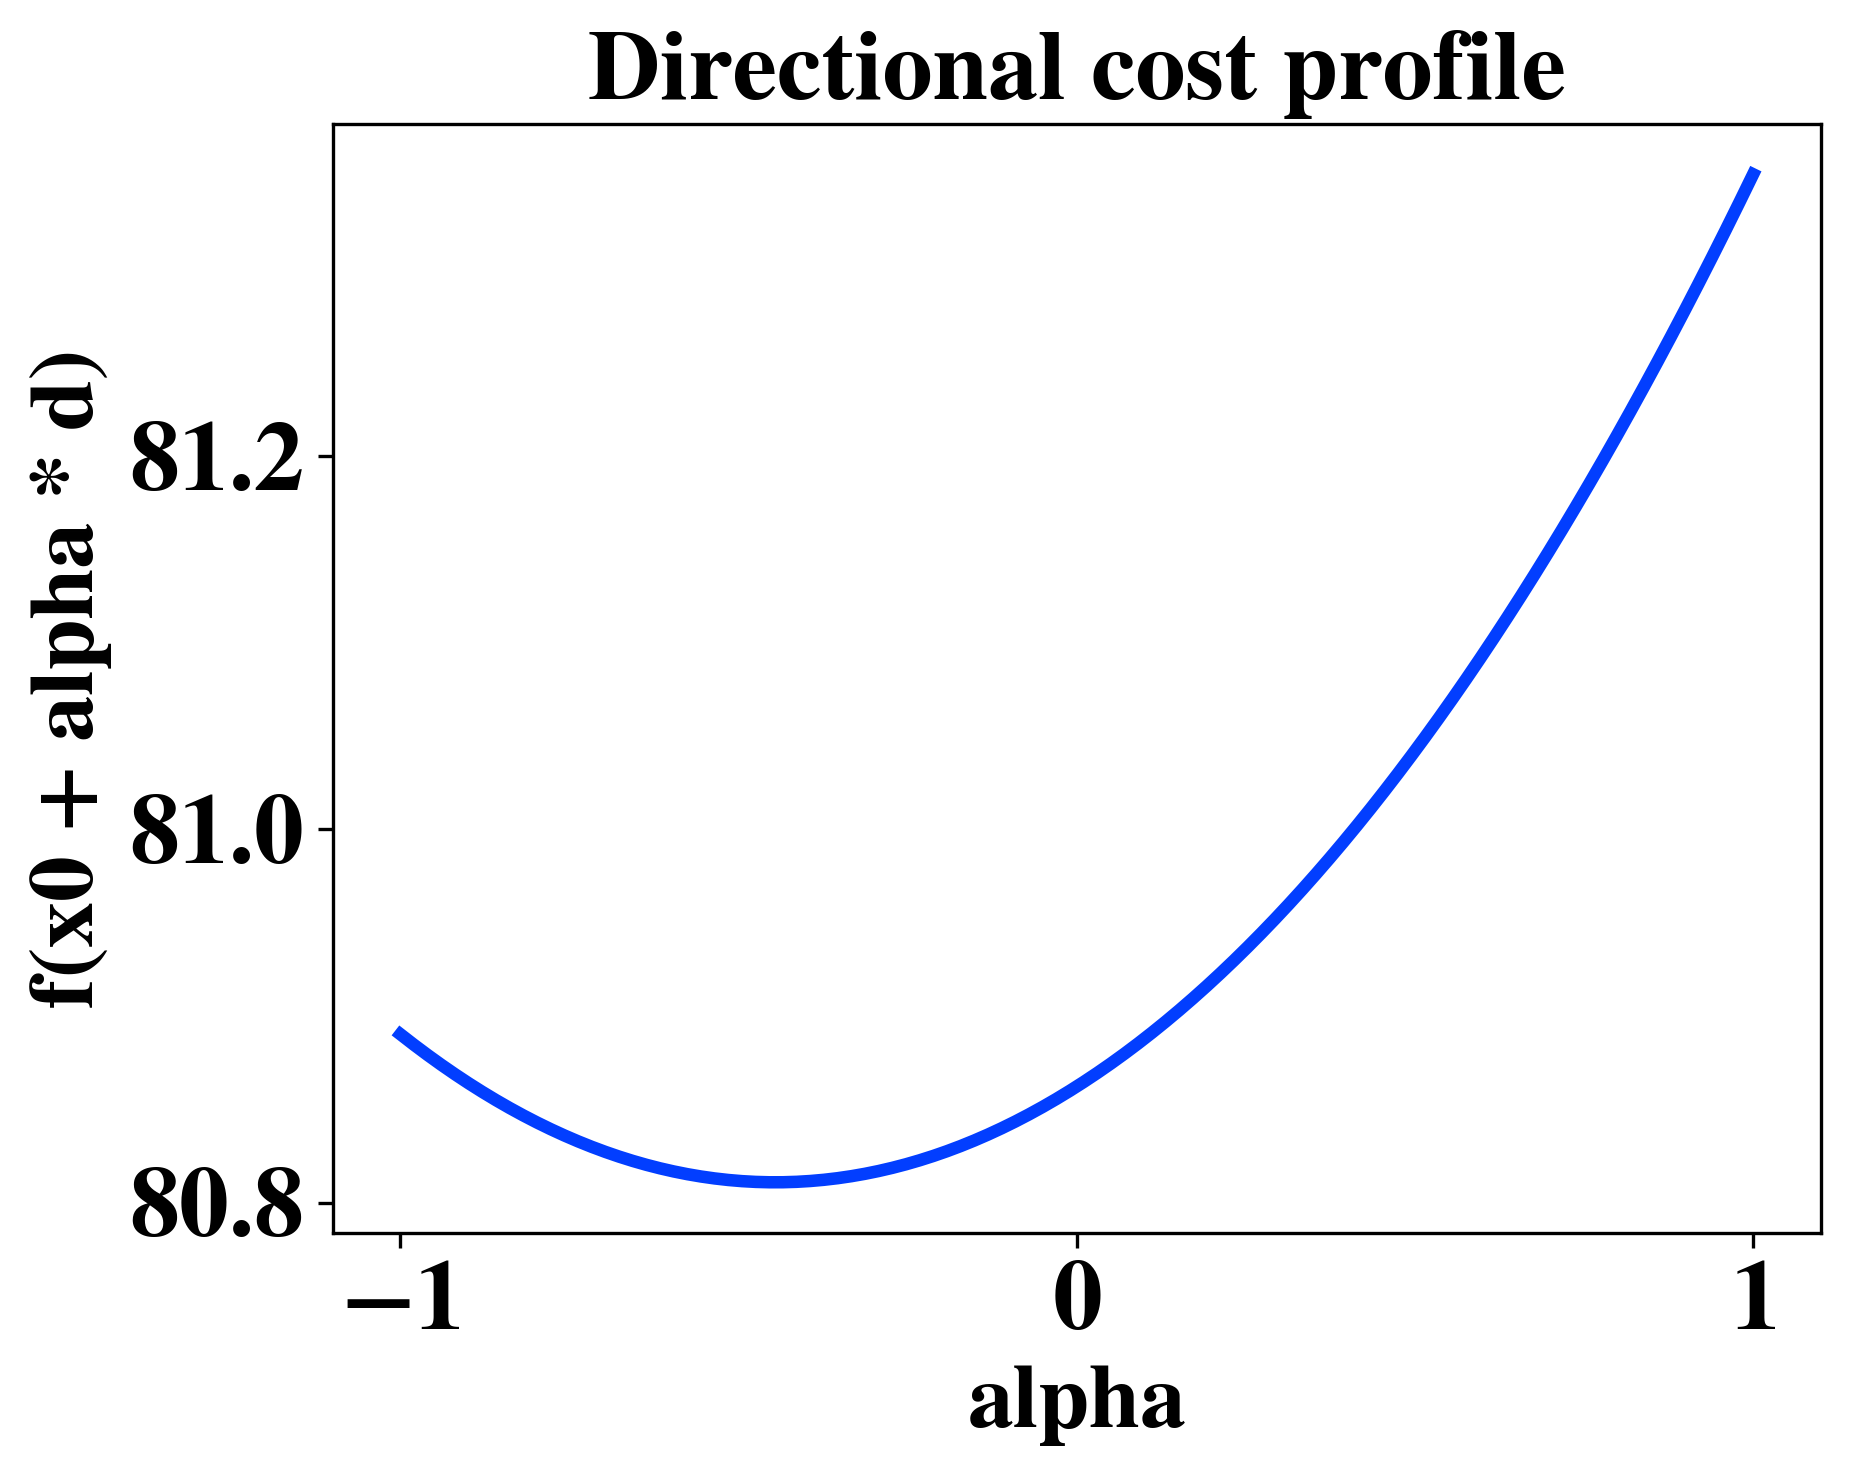

In [ ]:
# direction = np.random.randn(*z0.shape)
# direction /= np.linalg.norm(direction) 
direction = -grad_at_init / np.linalg.norm(grad_at_init)
alphas = np.linspace(-1, 1, 100)
vals = []

for alpha in alphas: 
    z = z0 + alpha * direction
    cost = cost_fn(z)
    vals.append(cost)
    # print(f"Alpha: {alpha}, Cost: {cost}")


plt.plot(alphas, vals)
plt.xlabel("alpha")
plt.ylabel("f(x0 + alpha * d)")
plt.title("Directional cost profile")
plt.show()

In [ ]:
def cost_function_gradient1(z0, epsilon=1e-6):
    """
    Efficient forward finite difference gradient.
    """
    z0 = np.asarray(z0)
    grad = np.empty_like(z0)
    J_base = cost_fn(z0)

    x_perturbed = z0.copy()

    for i in range(z0.size):
        old_val = x_perturbed[i]
        x_perturbed[i] = old_val + epsilon

        grad[i] = (cost_fn(x_perturbed) - J_base) / epsilon

        x_perturbed[i] = old_val  # restore in-place

    return grad


def cost_function_gradient2(z0, epsilon=1e-6):
    """
    Compute the gradient of the cost function using forward finite differences.
    """
    grad = np.empty_like(z0)
    J_base = cost_fn(z0)

    x_perturbed = z0.copy()

    for i in range(len(z0)):
        x_perturbed[i] = z0[i] + epsilon
        J_plus = cost_fn(x_perturbed)
        grad[i] = (J_plus - J_base) / epsilon
        x_perturbed[i] = z0[i]  # Reset to original value

    return grad


def cost_function_gradient3(z0, epsilon=1e-6):
    """
    Optimized forward finite difference gradient using vectorization.
    """
    z0 = np.asarray(z0)
    n = z0.size
    J_base = cost_fn(z0)
    
    # Create a matrix where each row is z0 with one element perturbed
    perturbations = np.eye(n) * epsilon
    z_perturbed = z0.reshape(1, -1) + perturbations
    
    # Compute all perturbed cost function values at once
    J_perturbed = np.array([cost_fn(z) for z in z_perturbed])
    
    # Calculate all gradients at once
    grad = (J_perturbed - J_base) / epsilon
    
    return grad 


def cost_function_gradient4(z0, epsilon=1e-6, batch_size=5):
    """
    Batched forward finite difference gradient for large arrays.
    """
    z0 = np.asarray(z0)
    n = z0.size
    J_base = cost_fn(z0)
    grad = np.empty(n)
    
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)
        batch_size_actual = end - i
        
        # Create batch of perturbations
        perturbations = np.eye(batch_size_actual) * epsilon
        z_batch = np.tile(z0, (batch_size_actual, 1))
        z_batch[:, i:end] += perturbations
        
        # Compute batch of cost function values
        J_perturbed = np.array([cost_fn(z) for z in z_batch])
        
        # Calculate batch of gradients
        grad[i:end] = (J_perturbed - J_base) / epsilon
        
    return grad

In [ ]:

epsilon = np.sqrt(np.finfo(float).eps)  # ≈ 1.49e-8
# Analytic gradient
grad_analytic = cost_function_gradient1(z0)

# Numerical gradient via forward finite differences
grad_numerical = approx_fprime(z0, cost_fn, epsilon)

error = np.linalg.norm(grad_analytic - grad_numerical)
rel_error = error / (np.linalg.norm(grad_numerical) + 1e-12)

print("Gradient error:", error)
print("Relative error:", rel_error)


Gradient error: 1.024021508113475e-05
Relative error: 7.2117852941048715e-06


In [ ]:

epsilon = np.sqrt(np.finfo(float).eps)  # ≈ 1.49e-8
# Analytic gradient
grad_analytic = cost_function_gradient4(z0)

# Numerical gradient via forward finite differences
grad_numerical = approx_fprime(z0, cost_fn, epsilon)

error = np.linalg.norm(grad_analytic - grad_numerical)
rel_error = error / (np.linalg.norm(grad_numerical) + 1e-12)

print("Gradient error:", error)
print("Relative error:", rel_error)


Gradient error: 4.615039961807716e-06
Relative error: 1.2891154315753199e-06


In [ ]:
grad_numerical = approx_fprime(z0, cost_fn, epsilon)

In [ ]:
grad_analytic1 = cost_function_gradient1(z0,epsilon)

In [ ]:
grad_analytic2 = cost_function_gradient2(z0,epsilon)

In [ ]:
grad_analytic3 = cost_function_gradient3(z0,epsilon)

In [ ]:
grad_analytic4 = cost_function_gradient4(z0,epsilon)